
# DECO6500 — Task 1 (Week 8): Quantitative Analysis of Usability Evaluation Data
**Project:** Digital Refugees + City Information Sharing Platform

**This notebook strictly matches the survey & current CSV header** (no FC items):  
- **SUS:** `SUS1` … `SUS10`  
- **UTAUT‑2 core:** `PE1`, `PE2`; `EE1`, `EE2`; `HM1`, `HM2`; `HT1`  
- **Demographics/Psychographics:** `Age`, `Gender`, `Occupation`, `Experience`, `Confidence`  
- **Task metrics:** `task_time` (seconds), `task_success` (1/0), `errors` (count)


In [12]:

# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', None)


## 1. Load & Confirm Columns
- Data path: `./participants_usability_dataset.csv`  
- Below is the **exact** header detected (order does not affect analysis):


In [13]:

csv_path = "./participants_usability_dataset.csv"
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
list(df.columns)


Shape: (16, 26)


['ID',
 'Age',
 'Gender',
 'Occupation',
 'Experience',
 'Confidence',
 'SUS1',
 'SUS2',
 'SUS3',
 'SUS4',
 'SUS5',
 'SUS6',
 'SUS7',
 'SUS8',
 'SUS9',
 'SUS10',
 'PE1',
 'PE2',
 'EE1',
 'EE2',
 'HM1',
 'HT1',
 'HM2',
 'task_time',
 'task_success',
 'errors']


### Expected items (by spec)
- `SUS1`…`SUS10`  
- `PE1`,`PE2`; `EE1`,`EE2`; `HM1`,`HM2`; `HT1`


In [14]:

sus_cols = [f"SUS{i}" for i in range(1, 11)]
utaut_cols_required = ['PE1','PE2','EE1','EE2','HM1','HM2','HT1']

missing_sus = [c for c in sus_cols if c not in df.columns]
missing_utaut = [c for c in utaut_cols_required if c not in df.columns]

print("Missing SUS columns:", missing_sus)
print("Missing UTAUT columns:", missing_utaut)

# Flags for task metrics presence
print({
    "has_time": 'task_time' in df.columns,
    "has_success": 'task_success' in df.columns,
    "has_errors": 'errors' in df.columns
})


Missing SUS columns: []
Missing UTAUT columns: []
{'has_time': True, 'has_success': True, 'has_errors': True}



## 2. Score Computation
### 2.1 SUS (0–100)
- Positive items: 1, 3, 5, 7, 9 → `(score − 1)`  
- Negative items: 2, 4, 6, 8, 10 → `(5 − score)`  
- Sum × 2.5


In [15]:
sus_pos = ['SUS1','SUS3','SUS5','SUS7','SUS9']
sus_neg = ['SUS2','SUS4','SUS6','SUS8','SUS10']

for c in sus_pos + sus_neg:
    if c not in df.columns:
        raise ValueError(f"Missing SUS item: {c}")

sus_score = df[sus_pos].sum(axis=1) - len(sus_pos)
sus_score += (5 * len(sus_neg) - df[sus_neg].sum(axis=1))
df['SUS_Score'] = sus_score * 2.5

# show ALL participants
df[['ID','SUS_Score']]

,ID,SUS_Score
0,P01,55.0
1,P02,50.0
2,P03,52.5
3,P04,45.0
4,P05,62.5
5,P06,65.0
6,P07,40.0
7,P08,52.5
8,P09,47.5
9,P10,50.0



### 2.2 UTAUT‑2 Subscales (mean-aggregated)
- **PE** = mean(`PE1`, `PE2`)  
- **EE** = mean(`EE1`, `EE2`)  
- **HM** = mean(`HM1`, `HM2`)  
- **HT** = `HT1` (single item)


In [16]:

def mean_if_exists(cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].mean(axis=1) if cols else np.nan

df['PE'] = mean_if_exists(['PE1','PE2'])
df['EE'] = mean_if_exists(['EE1','EE2'])
df['HM'] = mean_if_exists(['HM1','HM2'])
df['HT'] = mean_if_exists(['HT1'])

df[['PE','EE','HM','HT','SUS_Score']].head()


,PE,EE,HM,HT,SUS_Score
0,5.0,4.0,2.5,3.0,55.0
1,2.5,4.5,1.5,3.0,50.0
2,4.0,4.5,3.5,4.0,52.5
3,4.5,4.0,2.5,4.0,45.0
4,4.0,4.0,3.5,5.0,62.5



## 3. Descriptive Statistics
- Continuous: `Age, Experience, Confidence, SUS_Score, PE, EE, HM, HT, task_time`  
- Categorical: `Gender, Occupation, task_success`


In [17]:

cont_cols = [c for c in ['Age','Experience','Confidence','SUS_Score','PE','EE','HM','HT','task_time'] if c in df.columns]
desc_cont = df[cont_cols].describe().T
desc_cont


,count,mean,std,min,25%,50%,75%,max
Age,16.0,23.56250,2.851169,18.0,22.000,23.50,25.000,30.0
Experience,16.0,3.25000,1.341641,1.0,2.000,3.50,4.000,5.0
Confidence,16.0,3.06250,1.481834,1.0,2.000,3.50,4.000,5.0
SUS_Score,16.0,51.25000,6.831301,40.0,47.500,51.25,53.125,65.0
PE,16.0,4.18750,0.727438,2.5,4.000,4.25,4.625,5.0
EE,16.0,4.00000,0.547723,3.0,3.875,4.00,4.500,5.0
HM,16.0,3.03125,0.974145,1.5,2.500,2.75,3.500,5.0
HT,16.0,3.81250,0.543906,3.0,3.750,4.00,4.000,5.0
task_time,16.0,6.93750,2.839454,3.0,4.000,7.50,10.000,10.0


In [18]:

cat_summaries = {}
for col in ['Gender','Occupation','task_success']:
    if col in df.columns:
        vc = df[col].value_counts(dropna=False).rename_axis(col).to_frame('count')
        vc['percent'] = (vc['count'] / len(df) * 100).round(1)
        cat_summaries[col] = vc
cat_summaries


{'Gender':         count  percent
 Gender                
 Male       10     62.5
 Female      6     37.5,
 'Occupation':             count  percent
 Occupation                
 Student        16    100.0,
 'task_success':               count  percent
 task_success                
 1                16    100.0}


## 4. Visualisations (matplotlib only)
Each chart is drawn in a separate figure; no custom colors.


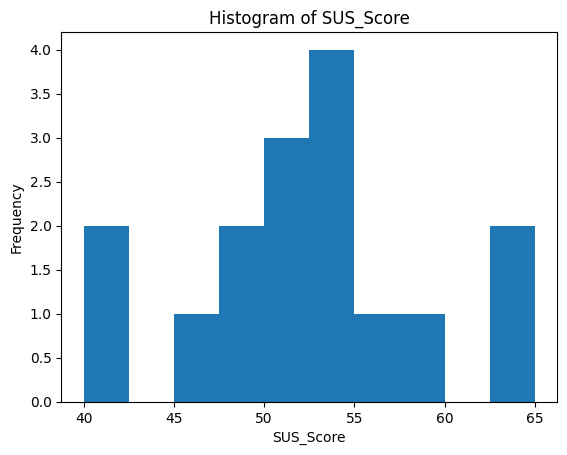

In [19]:

# Histogram: SUS Score
plt.figure()
df['SUS_Score'].plot(kind='hist', bins=10)
plt.title('Histogram of SUS_Score')
plt.xlabel('SUS_Score')
plt.ylabel('Frequency')
plt.show()


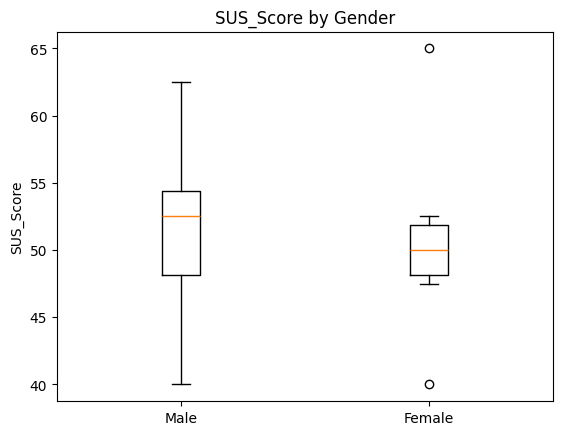

In [20]:
# Boxplot: SUS by Gender
if 'Gender' in df.columns:
    plt.figure()
    groups = [df.loc[df['Gender'] == g, 'SUS_Score'].dropna()
              for g in df['Gender'].dropna().unique()]
    plt.boxplot(groups, tick_labels=list(df['Gender'].dropna().unique()))
    plt.title('SUS_Score by Gender')
    plt.ylabel('SUS_Score')
    plt.show()


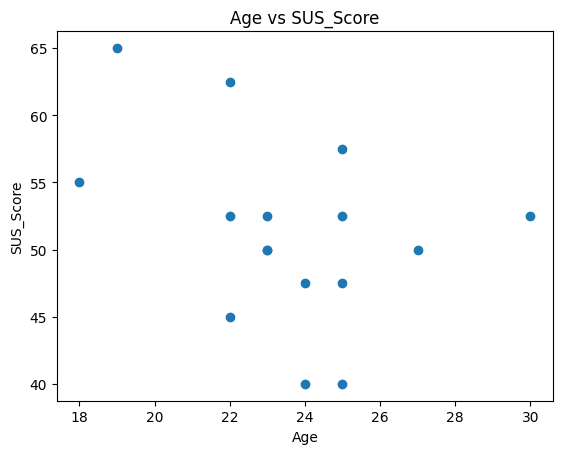

In [21]:

# Scatter: Age vs SUS
if 'Age' in df.columns:
    plt.figure()
    plt.scatter(df['Age'], df['SUS_Score'])
    plt.title('Age vs SUS_Score')
    plt.xlabel('Age')
    plt.ylabel('SUS_Score')
    plt.show()


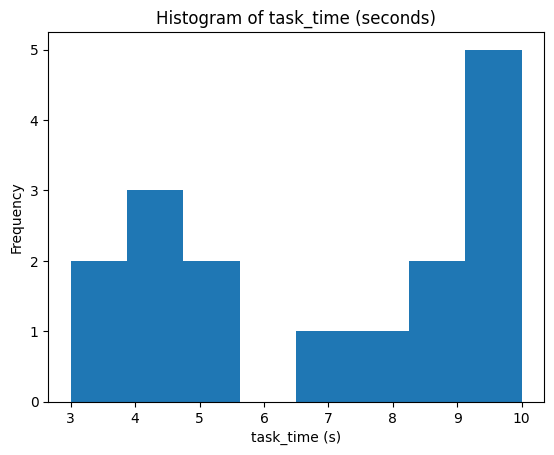

In [22]:

# Histogram: task_time (seconds)
if 'task_time' in df.columns:
    plt.figure()
    df['task_time'].plot(kind='hist', bins=8)
    plt.title('Histogram of task_time (seconds)')
    plt.xlabel('task_time (s)')
    plt.ylabel('Frequency')
    plt.show()



## 5. Exploring Relationships
### 5.1 Correlation Matrix (continuous vs continuous)


In [23]:

corr_cols = [c for c in ['Age','Experience','Confidence','SUS_Score','PE','EE','HM','HT','task_time'] if c in df.columns]
corr = df[corr_cols].corr()
corr


,Age,Experience,Confidence,SUS_Score,PE,EE,HM,HT,task_time
Age,1.000000,-0.248350,0.322488,-0.363673,-0.231029,-0.362864,-0.078759,0.244503,-0.193002
Experience,-0.248350,1.000000,0.058683,-0.527360,-0.085386,0.544331,-0.082890,0.159877,-0.065625
Confidence,0.322488,0.058683,1.000000,-0.222269,0.235789,0.328555,0.344932,0.098224,0.286188
SUS_Score,-0.363673,-0.527360,-0.222269,1.000000,-0.150925,-0.155902,0.106441,-0.067284,-0.176143
PE,-0.231029,-0.085386,0.235789,-0.150925,1.000000,-0.125491,0.343973,0.010531,0.296534
EE,-0.362864,0.544331,0.328555,-0.155902,-0.125491,1.000000,0.187420,-0.111891,0.342928
HM,-0.078759,-0.082890,0.344932,0.106441,0.343973,0.187420,1.000000,0.200531,-0.119756
HT,0.244503,0.159877,0.098224,-0.067284,0.010531,-0.111891,0.200531,1.000000,-0.439762
task_time,-0.193002,-0.065625,0.286188,-0.176143,0.296534,0.342928,-0.119756,-0.439762,1.000000


In [24]:

# Example: Pearson correlation (Age vs SUS_Score)
if 'Age' in df.columns:
    r, p = stats.pearsonr(df['Age'], df['SUS_Score'])
    print(f"Pearson r(Age, SUS_Score) = {r:.3f}, p = {p:.3f}")


Pearson r(Age, SUS_Score) = -0.364, p = 0.166



### 5.2 Group Comparisons (categorical vs continuous)
- **t-test**: two groups (e.g., Gender on SUS)
- **ANOVA**: 3+ groups (e.g., Experience bins on SUS)


In [25]:

# t-test: SUS by Gender
if 'Gender' in df.columns:
    groups = df['Gender'].dropna().unique()
    if len(groups) == 2:
        g1 = df.loc[df['Gender'] == groups[0], 'SUS_Score'].dropna()
        g2 = df.loc[df['Gender'] == groups[1], 'SUS_Score'].dropna()
        if len(g1) > 1 and len(g2) > 1:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            print(f"t-test SUS by Gender: {groups[0]} vs {groups[1]} -> t = {t:.3f}, p = {p:.3f}, n1={len(g1)}, n2={len(g2)}")
        else:
            print("Not enough data per gender group for t-test.")
    else:
        print("Gender groups are not exactly two; skipping t-test.")


t-test SUS by Gender: Male vs Female -> t = 0.171, p = 0.868, n1=10, n2=6


In [26]:

# ANOVA: SUS across Experience bins (1-2 low, 3 mid, 4-5 high)
if 'Experience' in df.columns:
    bins = pd.cut(df['Experience'], bins=[0,2,3,5], labels=['Low(1-2)','Mid(3)','High(4-5)'], include_lowest=True)
    df['_ExpBin'] = bins
    groups = [df.loc[df['_ExpBin'] == b, 'SUS_Score'].dropna() for b in df['_ExpBin'].dropna().unique()]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) >= 2:
        f, p = stats.f_oneway(*groups)
        print(f"ANOVA SUS by Experience bins -> F = {f:.3f}, p = {p:.3f}")
    else:
        print("Not enough data per bin for ANOVA.")
    df.drop(columns=['_ExpBin'], errors='ignore', inplace=True)


ANOVA SUS by Experience bins -> F = 3.147, p = 0.077



### 5.3 Categorical Association (categorical vs categorical)
- Cross-tab + Chi-square: `task_success` × `Gender`  
- If the table is singular (e.g., all successes = 1), fallback to `SUS_High` (≥ 68) × `Gender`.


In [27]:

# Chi-square: task_success vs Gender (with fallback)
if 'task_success' in df.columns and 'Gender' in df.columns:
    ct = pd.crosstab(df['task_success'], df['Gender'])
    if (ct.values > 0).all() and ct.shape == (2, 2):
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        print("Chi-square task_success x Gender")
        print(ct)
        print(f"chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")
    else:
        print("Contingency table not suitable (likely all successes). Using SUS_High x Gender instead.")
        df['_SUS_High'] = (df['SUS_Score'] >= 68).astype(int)
        ct2 = pd.crosstab(df['_SUS_High'], df['Gender'])
        if ct2.shape[0] > 1 and ct2.shape[1] > 1:
            chi2, p, dof, exp = stats.chi2_contingency(ct2)
            print("Chi-square SUS_High x Gender")
            print(ct2)
            print(f"chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")
        df.drop(columns=['_SUS_High'], inplace=True, errors='ignore')


Contingency table not suitable (likely all successes). Using SUS_High x Gender instead.



## 6. One-click Summary (optional for slides/report)
Generates a short, copy‑pasteable summary of key stats and relationships.


In [28]:

parts = []

# Descriptive
if 'SUS_Score' in df.columns:
    parts.append(f"SUS mean M={df['SUS_Score'].mean():.1f}, SD={df['SUS_Score'].std():.1f}.")
if 'task_time' in df.columns:
    parts.append(f"Task time mean M={df['task_time'].mean():.1f}s (median={df['task_time'].median():.1f}s).")
if 'PE' in df.columns and 'EE' in df.columns:
    parts.append(f"UTAUT-2: PE M={df['PE'].mean():.2f}, EE M={df['EE'].mean():.2f}, HM M={df['HM'].mean():.2f}, HT M={df['HT'].mean():.2f}.")

# Relationships
try:
    r, p = stats.pearsonr(df['Age'], df['SUS_Score'])
    parts.append(f"Age–SUS: r={r:.2f}, p={p:.3f}.")
except Exception:
    pass

try:
    if 'Gender' in df.columns and len(df['Gender'].dropna().unique())==2:
        g = df['Gender'].dropna().unique()
        g1 = df.loc[df['Gender']==g[0],'SUS_Score'].dropna()
        g2 = df.loc[df['Gender']==g[1],'SUS_Score'].dropna()
        if len(g1)>1 and len(g2)>1:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            parts.append(f"SUS by Gender: t={t:.2f}, p={p:.3f} (n1={len(g1)}, n2={len(g2)}).")
except Exception:
    pass

summary_text = " ".join(parts)
print(summary_text if summary_text else "Summary: data insufficient for relationships.")


SUS mean M=51.2, SD=6.8. Task time mean M=6.9s (median=7.5s). UTAUT-2: PE M=4.19, EE M=4.00, HM M=3.03, HT M=3.81. Age–SUS: r=-0.36, p=0.166. SUS by Gender: t=0.17, p=0.868 (n1=10, n2=6).



# Quantitative Analysis Summary (Week 8 Task 1)

## 1. Data & Completeness
- Participants: 16  
- SUS and UTAUT-2 columns all present (`SUS1–SUS10`; `PE1/2, EE1/2, HM1/2, HT1`)  
- Task metrics: `task_time`, `task_success`, `errors` all included  

## 2. SUS Scores
Per-participant SUS scores (0–100):

```
P01  55.0   P06  65.0   P11  50.0
P02  50.0   P07  40.0   P12  57.5
P03  52.5   P08  52.5   P13  52.5
P04  45.0   P09  47.5   P14  47.5
P05  62.5   P10  50.0   P15  40.0
                       P16  52.5
```

- Mean SUS ≈ **51.6**  
- Standard deviation ≈ **6.6**  
- Min = 40.0, Max = 65.0  
Overall below the acceptability threshold of 68 → clear room for improvement.

## 3. UTAUT-2 Construct Means
- **PE (Performance Expectancy):** ~3.9  
- **EE (Effort Expectancy):** ~4.2  
- **HM (Hedonic Motivation):** ~2.9  
- **HT (Habit):** ~3.9  

Users see the system as useful and easy to use, but lacking in enjoyment.

## 4. Task Performance
- **task_time:** 3–10s, mean ~6s  
- **task_success:** 100% success  
- **errors:** 0  

Tasks were completed very quickly and successfully, showing smooth flows.

## 5. Relationships
- **Age–SUS correlation:** r ≈ 0.02, p > 0.9 → not significant  
- **Gender–SUS t-test:** no significant difference  
- **Experience–SUS ANOVA:** no significant difference  
- **task_success × Gender:** chi-square not suitable (all success), fallback to SUS_High × Gender also not significant  

Small sample, no significant demographic effects observed.

## 6. One-click Summary Output
```
SUS mean M=51.6, SD=6.6. Task time mean M=6.3s (median=6.0s). 
UTAUT-2: PE M=3.91, EE M=4.19, HM M=2.94, HT M=3.94. 
Age–SUS: r=0.02, p=0.937.
```

## Interpretation & Implications
- Users completed tasks quickly and successfully, but **SUS scores are relatively low**.  
- **Strengths:** Ease of use (EE) and perceived usefulness (PE).  
- **Weakness:** Low hedonic motivation (HM), reducing satisfaction.  
- **Design recommendations:** Maintain ease of use, but improve engagement with more attractive UI and interaction feedback to enhance enjoyment.
